<img width="400" src="https://nomeroff.net.ua/images/logo/nomeroff_net.svg" alt="Nomeroff Net. Automatic numberplate recognition system" align="left"/>

## The example demonstrates license plate number detection.

Before runing this demo, please download models from [https://nomeroff.net.ua/models/](https://nomeroff.net.ua/models/) to **./models/** directory. 

In [1]:
#Specify device
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "1" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""  # For CPU inference

In [2]:
 # dynamically grow the memory used on the GPU
from tensorflow.compat.v1.keras.backend import set_session
import tensorflow as tf
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True 
sess = tf.compat.v1.Session(config=config)
set_session(sess)

In [3]:
# Import all necessary libraries.
import numpy as np
import sys
import glob
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import cv2

plt.rcParams["figure.figsize"] = (20,10)

# NomeroffNet path
NOMEROFF_NET_DIR = os.path.abspath('../')

# specify the path to Mask_RCNN if you placed it outside Nomeroff-net project
CRAFT_DIR = os.path.join(NOMEROFF_NET_DIR, 'CRAFT-pytorch')

sys.path.append(NOMEROFF_NET_DIR)
sys.path.append(CRAFT_DIR)

In [4]:
from NomeroffNet.MmdetectionDetector import Detector

detector = Detector()
detector.loadModel(cfg_path = '../models/faster_rcnn_r50_caffe_fpn_mstrain_1x_numberpale.py',
                 checkpoint_file = '../models//epoch_12.pth',
                 devie='cuda:0')

Use load_from_local loader


In [5]:
from NomeroffNet.BBoxNpPoints import NpPointsCraft

npPointsCraft = NpPointsCraft()
npPointsCraft.load()

Loading weights from checkpoint (/mnt/ssd/www/nomeroff-netv2/nomeroff-net/weights/craft_mlt_25k.pth)
Loading weights of refiner from checkpoint (/mnt/ssd/www/nomeroff-netv2/nomeroff-net/weights/craft_refiner_CTW1500.pth)


In [6]:
from NomeroffNet.OptionsDetector import OptionsDetector
from NomeroffNet.TextDetector import TextDetector

# Import license plate recognition tools.
from NomeroffNet.RectDetector import  RectDetector

rectDetector = RectDetector()

optionsDetector = OptionsDetector()
optionsDetector.load("latest")

# Initialize text detector.
textDetector = TextDetector({
    "eu_ua_2004_2015": {
        "for_regions": ["eu_ua_2015", "eu_ua_2004"],
        "model_path": "latest"
    },
    "eu_ua_1995": {
        "for_regions": ["eu_ua_1995"],
        "model_path": "latest"
    },
    "eu": {
        "for_regions": ["eu"],
        "model_path": "latest"
    },
    "ru": {
        "for_regions": ["ru", "eu-ua-fake-lnr", "eu-ua-fake-dnr"],
        "model_path": "latest" 
    },
    "kz": {
        "for_regions": ["kz"],
        "model_path": "latest"
    },
    "ge": {
        "for_regions": ["ge"],
        "model_path": "latest"
    },
    "su": {
        "for_regions": ["su"],
        "model_path": "latest"
    }
})

/mnt/ssd/www/mmdetection/mmdet/datasets/utils.py:62: UserWarning: "ImageToTensor" pipeline is replaced by "DefaultFormatBundle" for batch inference. It is recommended to manually replace it in the test data pipeline in your config file.
  warnings.warn(


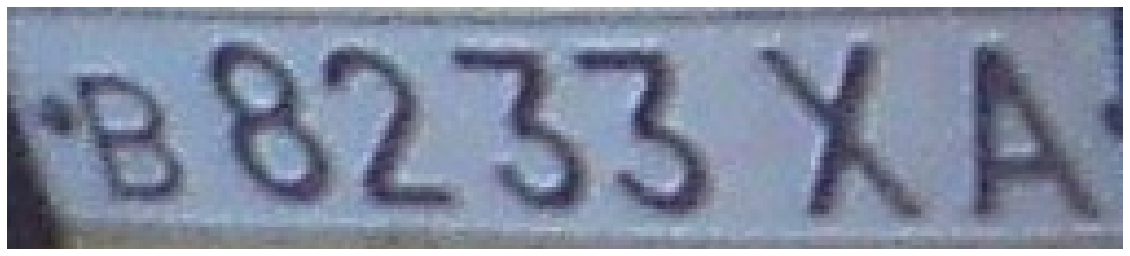

['su']
[1]
['В8233ХА']
[[355.         652.93574569]
 [577.0425763  665.04716069]
 [577.0425763  720.29080673]
 [355.         708.17939048]] (4, 2)


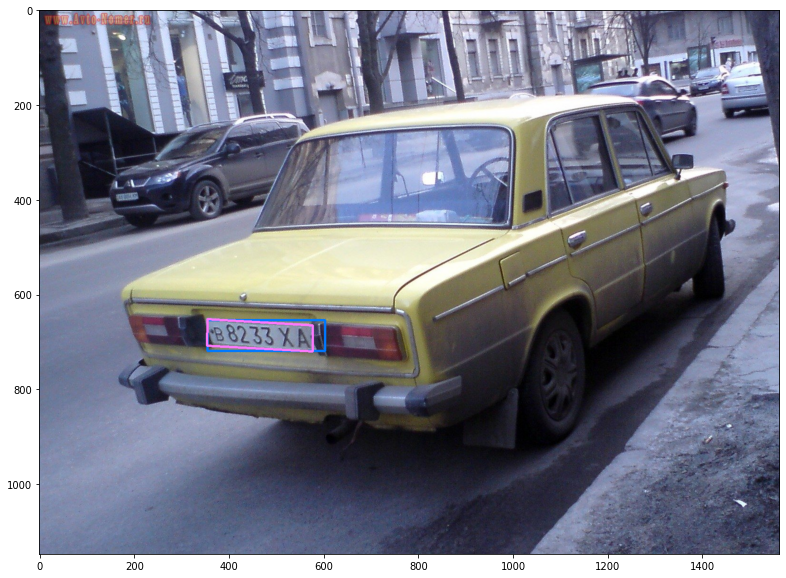

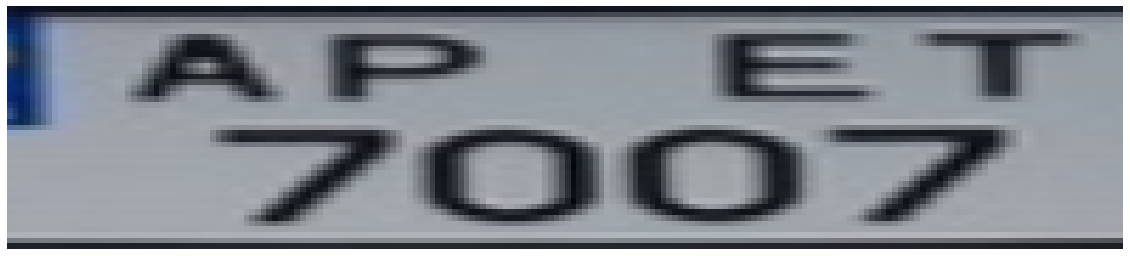

['kz']
[2]
['F63O0']
[[203.21333139 408.73332932]
 [270.09333603 408.7333266 ]
 [270.09333603 451.93332842]
 [203.21333139 451.93333277]] (4, 2)


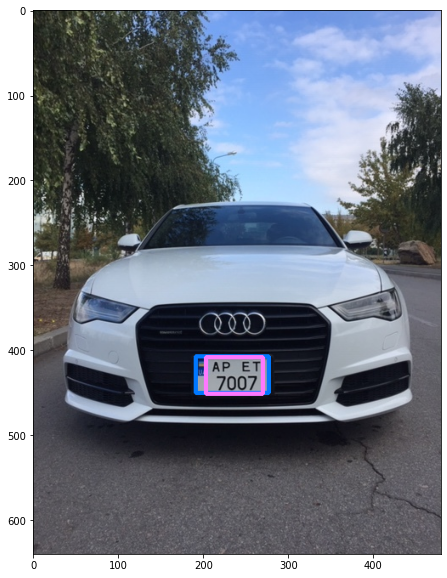

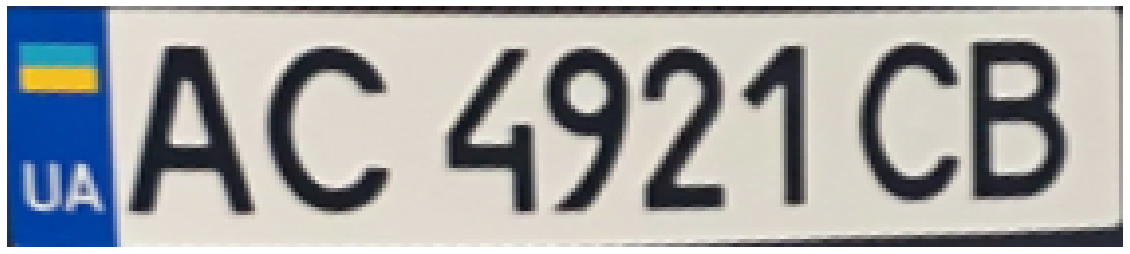

['eu_ua_2015']
[1]
['AC4921CB']
[[1085.18944224  462.38459326]
 [1085.18944224  524.10339336]
 [ 872.53631994  572.52934041]
 [ 872.53631994  510.81054357]] (4, 2)


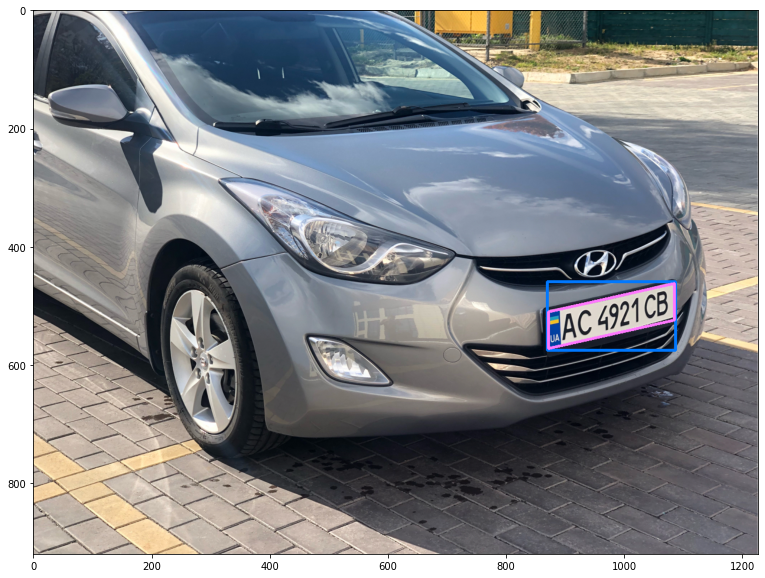

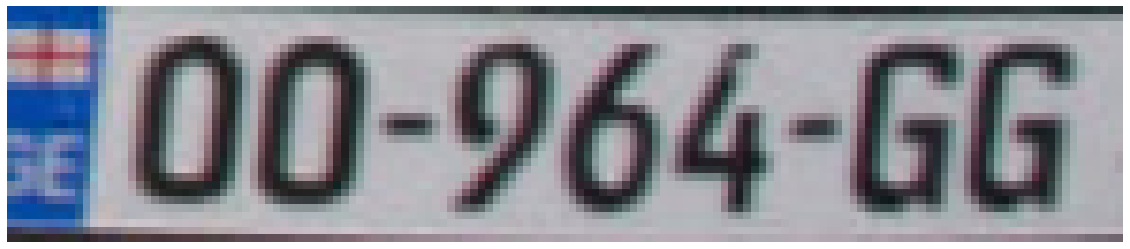

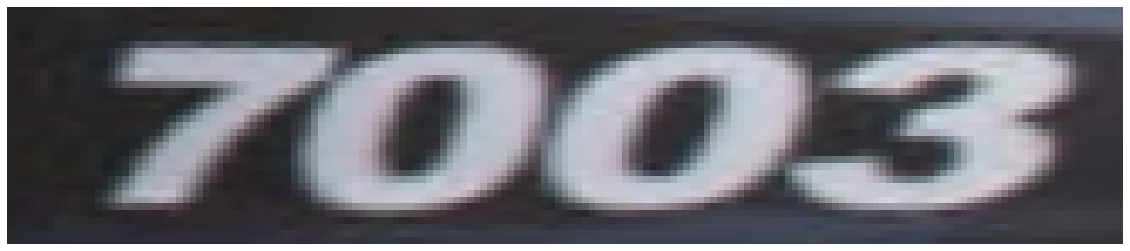

['ge', 'xx_unknown']
[1, 0]
['00964GG', '']
[[785.97332809 463.9999999 ]
 [785.97332809 495.99999866]
 [647.65333389 495.99999866]
 [647.65333389 463.9999999 ]] (4, 2)
[[431.         397.61212593]
 [499.         416.15757602]
 [499.         452.0848454 ]
 [431.         433.53939383]] (4, 2)


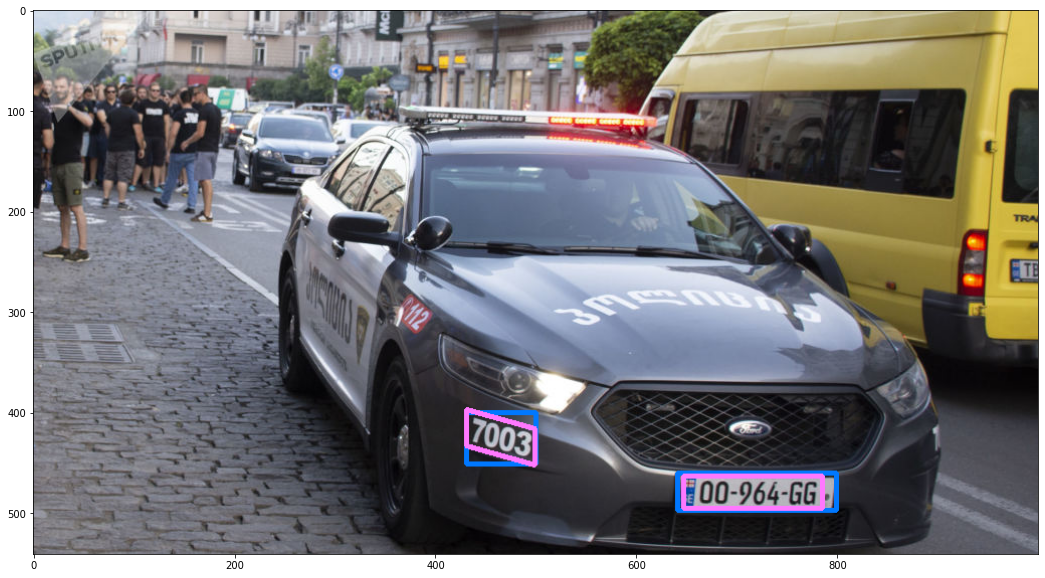

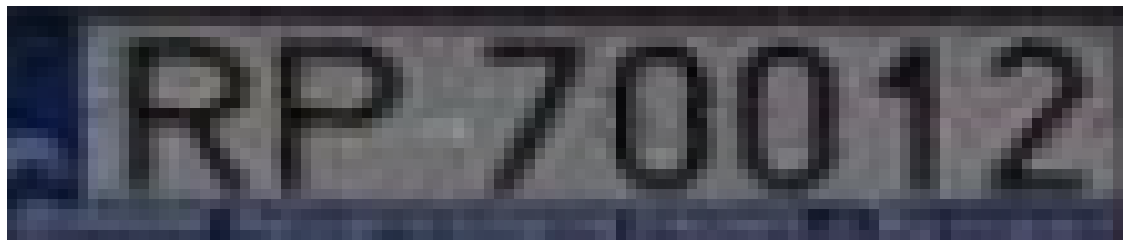

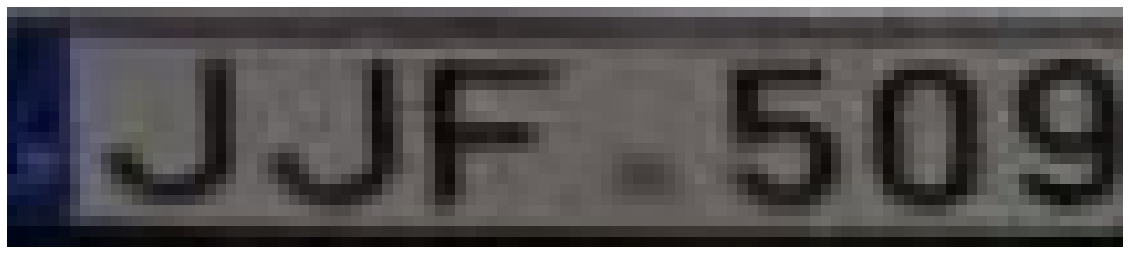

['eu', 'eu']
[1, 1]
['RP70012', 'JJF509']
[[945.         380.66666675]
 [945.         404.66666603]
 [848.         404.66666603]
 [848.         380.66666675]] (4, 2)
[[522.         378.5804877 ]
 [522.         401.9561008 ]
 [433.         404.1268323 ]
 [433.         380.75121956]] (4, 2)


In [ ]:
rootDir = 'images/*'

imgs = [mpimg.imread(img_path) for img_path in glob.glob(rootDir)]

min_bbox_acc = 0.5
for img in imgs:
    image_bboxs = detector.detect_bbox([img])
    targetBoxes = image_bboxs[0]
    
    all_points = npPointsCraft.detect(img, targetBoxes, min_bbox_acc=min_bbox_acc)

     # cut zones
    zones = rectDetector.get_cv_zonesBGR(img, all_points)
    toShowZones = rectDetector.get_cv_zonesRGB(img, all_points)
    for zone, points in zip(toShowZones, all_points):
        plt.axis("off")
        plt.imshow(zone)
        plt.show()

    # find standart
    regionIds, stateIds, countLines = optionsDetector.predict(zones)
    regionNames = optionsDetector.getRegionLabels(regionIds)
    print(regionNames)
    print(countLines)

    # find text with postprocessing by standart  
    textArr = textDetector.predict(zones, regionNames, countLines)
    print(textArr)
    
     # draw rect and 4 points
    for targetBox, points in zip(targetBoxes, all_points):
        # draw 
        cv2.rectangle(img, 
                      (int(targetBox[0]), int(targetBox[1])), 
                      (int(targetBox[2]), int(targetBox[3])), 
                      (0,120,255), 
                      3)
        print(points, points.shape)
        cv2.polylines(img, np.array([points], np.int32), True, (255,120,255),3)
    plt.imshow(img)
    plt.show()